In [36]:
import math

import numpy as np
import operator
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import sys

In [37]:
def plot_solution(solution, N):
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_xlim((0, N))
    ax.set_ylim((0, N))

    count = 0
    for queen in solution:
        ax.add_patch(patches.Rectangle((queen, count), 1, 1))
        count += 1
    plt.show()

In [ ]:
#N = Número de rainhas
N = 128


#Funções extraídas do código original do livro
#https://github.com/aimacode/aima-python
def actions(self, state):
        """In the leftmost empty column, try all non-conflicting rows."""
        if state[-1] != -1:
            return []  # All columns filled; no successors
        else:
            col = state.index(-1)
            return [row for row in range(self.N)
                    if not self.conflicted(state, row, col)]

def result(self, state, row):
        """Place the next queen at the given row."""
        col = state.index(-1)
        new = list(state[:])
        new[col] = row
        return tuple(new)


def conflicted(state, row, col):
    """Would placing a queen at (row, col) conflict with anything?"""
    return any(conflict(row, col, state[c], c)
               for c in range(col))

def conflict(row1, col1, row2, col2):
    """Would putting two queens in (row1, col1) and (row2, col2) conflict?"""
    return (row1 == row2 or  # same row
            col1 == col2 or  # same column
            row1 - col1 == row2 - col2 or  # same \ diagonal
            row1 + col1 == row2 + col2)  # same / diagonal

def goal_test(state):
    """Check if all columns filled, no conflicts."""
    if state[-1] == -1:
        return False
    return not any(conflicted(state, state[col], col)
                   for col in range(len(state)))

def h(node):
    """Return number of conflicting queens for a given node"""
    num_conflicts = 0
    for (r1, c1) in enumerate(node):
        for (r2, c2) in enumerate(node):
            if (r1, c1) != (r2, c2):
                num_conflicts += conflict(r1, c1, r2, c2)
    return -num_conflicts

In [236]:
def FindVizn(vizinhos, estado):
    viz_h = []
    for v in vizinhos:
        viz_h.append(h(v))
    melhores_V_ind = [i for i, x in enumerate(viz_h) if x == max(viz_h)]
    melhores_V = []
    for i in melhores_V_ind:
        melhores_V.append(vizinhos[i])
    selecionado = np.random.randint(0,len(melhores_V))
    melhor = melhores_V[selecionado]
    return melhor

def ProxEstado(N, estado):
    estados = []
    for linha in range(N):    
        for coluna in range(N):
            if coluna != estado[linha]:
                aux = list(estado)
                aux[linha] = coluna  
                estados.append(list(aux))  
    return estados

def HillClimbing(N,inicial):
    estado = inicial
    contador = 0
    contador_plato = 0
    log = []
    while True:
        log.append(h(estado))
        V = ProxEstado(N, estado)
        if not V:
            break
        Vz = FindVizn(V, inicial)
        if h(Vz) <= h(estado):
            break
        else:
            estado = Vz
            contador += 1 
    print("Número de passos: ", contador)
    print("Avaliação do resultado: ", -h(estado))
    return estado, log


def probability(p):
    return p > np.random.uniform(0.0, 1.0)

def exp_schedule(k = 35, lam = 0.015, limit = 100):
    return lambda t: (k * np.exp(-lam * t) if t < limit else 0)


# def SimulatedAnnealing(N, inicial = exp_schedule): # tentativa de codigo
    log = []
    estado = inicial
    contador = 0
    while True:
        log.append(h(estado))
        V = ProxEstado(N, estado)
        if not V:
            break    
        Vz = FindVizn(V,estado)
        if h(Vz) <= h(estado):
            break
        Prox = np.random.choice(Vz)
        delta_e = Prox - sum(estado)
     
        if delta_e > 0  or probability(np.exp(delta_e / len(V) )):
            estado = Prox
            contador+= 1
        print("Número de passos: ", contador)
        print("Avaliação do resultado: ", -h(estado))
        return estado, log   

In [276]:
from multiprocessing.sharedctypes import Value


class Problem:
    def __init__(self, initial, goal=None):
        self.initial = initial
        self.goal = goal

    def actions(self, state):
        raise NotImplementedError

    def result(self, state, action):
        raise NotImplementedError

    def goal_test(self, state):
        if isinstance(self.goal, list):
            return is_in(state, self.goal)
        else:
            return state == self.goal

    def path_cost(self, c, state1, action, state2):
        return c + 1

    def value(self, state):
        raise NotImplementedError


class Node:
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.depth = 0
        if parent:
            self.depth = parent.depth + 1

    def __repr__(self):
        return "<Node {}>".format(self.state)

    def __lt__(self, node):
        return self.state < node.state

    def expand(self, problem):
        return [self.child_node(problem, action)
                for action in problem.actions(self.state)]

    def child_node(self, problem, action):
        next_state = problem.result(self.state, action)
        next_node = Node(next_state, self, action, problem.path_cost(self.path_cost, self.state, action, next_state))
        return next_node

    def solution(self):
        return [node.action for node in self.path()[1:]]

    def path(self):
        node, path_back = self, []
        while node:
            path_back.append(node)
            node = node.parent
        return list(reversed(path_back))

    def __eq__(self, other):
        return isinstance(other, Node) and self.state == other.state

    def __hash__(self):
        return hash(self.state)
def simulated_annealing_full(problem, schedule=exp_schedule()):
    states = []
    current = Node(problem.initial)
    contador = 0
    for t in range(sys.maxsize):
        states.append(current.state)
        T = schedule(t)
        if T == 0:
            return states
        neighbors = current.expand(problem)
        if not neighbors:
            print('Num de Passo: '+str(contador))
            return current.state
        next_choice = np.random.choice(neighbors)
        delta_e = problem.value(next_choice.state) - problem.value(current.state)
        if delta_e > 0 or probability(np.exp(delta_e / T)):
            current = next_choice 
            contador += 1
            
            
class NQueensProblem(Problem):
   
    def __init__(self, N):
        super().__init__(tuple([-1] * N))
        self.N = N

    def actions(self, state):
       
        if state[-1] != -1:
            return []  # All columns filled; no successors
        else:
            col = state.index(-1)
            return [row for row in range(self.N)
                    if not self.conflicted(state, row, col)]

    def result(self, state, row):
        
        col = state.index(-1)
        new = list(state[:])
        new[col] = row
        return tuple(new)

    def conflicted(self, state, row, col):
       
        return any(self.conflict(row, col, state[c], c)
                   for c in range(col))

    def conflict(self, row1, col1, row2, col2):
        return (row1 == row2 or  # same row
                col1 == col2 or  # same column
                row1 - col1 == row2 - col2 or  # same \ diagonal
                row1 + col1 == row2 + col2)  # same / diagonal

    def goal_test(self, state):
        if state[-1] == -1:
            return False
        return not any(self.conflicted(state, state[col], col)
                       for col in range(len(state)))

    def h(self, node):

        num_conflicts = 0
        for (r1, c1) in enumerate(node.state):
            for (r2, c2) in enumerate(node.state):
                if (r1, c1) != (r2, c2):
                    num_conflicts += self.conflict(r1, c1, r2, c2)

        return num_conflicts
    
    def value(self, state):
        return sum(state)



In [ ]:
N = 128
resultado, log = HillClimbing(N, list(np.random.randint(0, N, N)))

plot_solution(resultado, N)

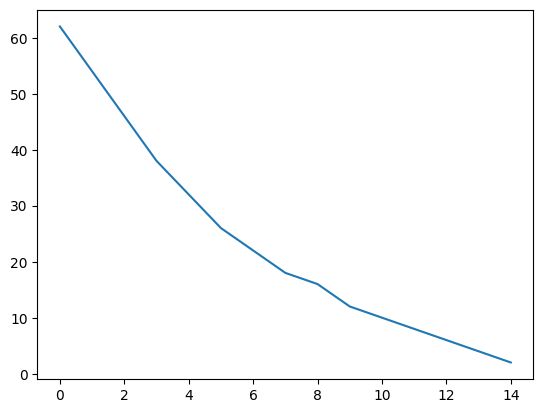

In [ ]:
plt.plot(abs(np.array(log)))
plt.show()

Num de Passo: 57


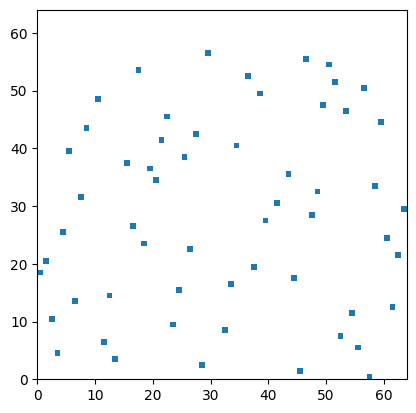

In [294]:
n = 64
N = NQueensProblem(n)
resultado = simulated_annealing_full(N,schedule=exp_schedule(k = n, lam = 0.015, limit = 300))
plot_solution(resultado, n)
# plt.plot(abs(np.array(log)))
# plt.show()